In [80]:
import pandas as pd
from collections import defaultdict
import os
from datetime import datetime
from scipy.stats import ttest_ind
from numpy import mean

In [114]:
#set constants

sources = ["Il Foglio", "Il Giornale", "La Nazione", "Libero"]

timerange = ('2019-11-20',
             '2019-12-03')

folder = '../outputs/fb/summary'

file_users =  '../config/users.csv'


In [115]:
#load all impressions, filtering useful fields and replacing hased names with fb names


def absoluteFilePaths(directory):
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            if str(f)[0] == '.':
                pass
            else:
                yield os.path.abspath(os.path.join(dirpath, f))

def getImpressions(folder):
    impressions = pd.DataFrame()
    files = absoluteFilePaths(folder)
    tokens2names = pd.read_csv(file_users)
    for impressions_file in files:
        user_impressions = pd.read_csv(impressions_file)[['impressionTime', 'user', 'source']] #you can add fields of interest here
        name = tokens2names[tokens2names['token'] == impressions_file.split('/')[-1].split('.')[0]]['name'].values[0]
        user_impressions['user'] = name
        impressions = pd.concat([impressions, user_impressions])      
    return impressions

impressions = getImpressions(folder)

In [116]:
#filter out for desired time range for experiment


impressions_exp = impressions[(impressions['impressionTime'] >= timerange[0]) 
                        & (impressions['impressionTime'] <= timerange[1])]

In [117]:
#cut impressionTime to aggregate posts in the same timeline

impressions_exp['timeline'] = [impressionTime[:15]
                               for impressionTime in impressions_exp['impressionTime']]


/home/berra/dashboard/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [118]:
#count specific sources per timeline

def count_sources_by_timeline(impressions, sources):
    sources_timelines = {"source": [],
                         "timeline": [],
                         "user": [],
                         "count": []}
    for source in sources:
        for user_timeline, timeline_impressions in impressions_exp.groupby(['user','timeline']):
            sources_timelines["source"].append(source)
            sources_timelines["timeline"].append(user_timeline)
            sources_timelines["user"].append(user_timeline[0])
            sources_timelines["count"].append(timeline_impressions[timeline_impressions["source"] == source]["source"].count())

    return pd.DataFrame(data = sources_timelines)

sources_timelines = count_sources_by_timeline(impressions_exp, sources)

In [119]:
#exclude salvini+lega in order to harmonize shares across polarized and control

impressions_exp = impressions_exp[(impressions_exp["source"] != "Matteo Salvini") 
                        & (impressions_exp["source"] != "Lega - Salvini Premier")]

sources_timelines.head()

,source,timeline,user,count
0,Il Foglio,"(Aarend, 2019-11-20 07:0)",Aarend,0
1,Il Foglio,"(Aarend, 2019-11-20 08:0)",Aarend,1
2,Il Foglio,"(Aarend, 2019-11-20 09:0)",Aarend,1
3,Il Foglio,"(Aarend, 2019-11-20 12:0)",Aarend,2
4,Il Foglio,"(Aarend, 2019-11-20 14:0)",Aarend,1


In [120]:

#normalize counts dividing for total impression per timeline

timeline_totalcount = impressions_exp.groupby(['user','timeline'])["source"].count()

sources_timelines["tot_count"] = [timeline_totalcount[timeline]
                                  for timeline in sources_timelines["timeline"]] 

sources_timelines["share_count"] = (sources_timelines["count"] / sources_timelines["tot_count"])*100



In [121]:
#drop timelinesif below a threeshold count

min_totcount = 10

sources_timelines = sources_timelines[sources_timelines["tot_count"] >= min_totcount]



In [122]:
#add column with test group the user belongs to
polarized_users = ('Aarend','Bjoke','CorTimmerman','Doortje','Erwijn','Friedie','Gert','Hanneke','Ivo','Juultje')

sources_timelines["user_group"] = ["polarized" if user in polarized_users 
                                               else "control" 
                                    for user in sources_timelines["user"]]



In [123]:
#compare means and run t-test

polarized = sources_timelines[sources_timelines['user_group'] == 'polarized']["share_count"]
control = sources_timelines[sources_timelines['user_group'] == 'control']["share_count"]


print(mean(polarized))
print(mean(control))

ttest_ind(polarized, control)

3.6822031858723725
3.305989262562424


Ttest_indResult(statistic=3.934990082376097, pvalue=8.387741240177982e-05)

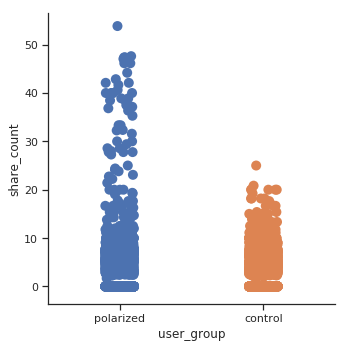

In [132]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)


groups_data = sources_timelines[["share_count","user_group"]]


sns.catplot(x= "user_group", y= "share_count", s=10, data= groups_data);